# **********************************************************************

### Attention Models

This is the toughest and most tricky part. If you are able to understand the intiuition and working of attention block , understanding transformers and transformer based architectures like BERT will be a piece of cake. This is the part where I spent the most time on and I suggest you do the same . Please read and view the following resources in the order I am providing to ignore getting confused, also at the end of this try to write and draw an attention block in your own way :-

* https://www.coursera.org/learn/nlp-sequence-models/lecture/RDXpX/attention-model-intuition --> Only watch this video and not the next one
* https://towardsdatascience.com/sequence-2-sequence-model-with-attention-mechanism-9e9ca2a613a
* https://towardsdatascience.com/attention-and-its-different-forms-7fc3674d14dc
* https://distill.pub/2016/augmented-rnns/

#### Code Implementation

* https://www.analyticsvidhya.com/blog/2019/11/comprehensive-guide-attention-mechanism-deep-learning/ --> Basic Level
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html ---> Implementation from Scratch in Pytorch

### Transformers : Attention is all you need

So finally we have reached the end of the learning curve and are about to start learning the technology that changed NLP completely and are the reasons for the state of the art NLP techniques .Transformers were introduced in the paper Attention is all you need by Google. If you have understood the Attention models,this will be very easy , Here is transformers fully explained:

* http://jalammar.github.io/illustrated-transformer/

#### Code Implementation

* http://nlp.seas.harvard.edu/2018/04/03/attention.html ---> This presents the code implementation of the architecture presented in the paper by Google

### BERT and Its Implementation on this Competition

As Promised I am back with Resiurces , to understand about BERT architecture , please follow the contents in the given order :-

* http://jalammar.github.io/illustrated-bert/ ---> In Depth Understanding of BERT

After going through the post Above , I guess you must have understood how transformer architecture have been utilized by the current SOTA models . Now these architectures can be used in two ways :<br><br>
1) We can use the model for prediction on our problems using the pretrained weights without fine-tuning or training the model for our sepcific tasks
* EG: http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/ ---> Using Pre-trained BERT without Tuning

2) We can fine-tune or train these transformer models for our task by tweaking the already pre-trained weights and training on a much smaller dataset
* EG:* https://www.youtube.com/watch?v=hinZO--TEk4&t=2933s ---> Tuning BERT For your TASK

We will be using the first example as a base for our implementation of BERT model using Hugging Face and KERAS , but contrary to first example we will also Fine-Tune our model for our task

Acknowledgements : https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras


Steps Involved :
* Data Preparation : Tokenization and encoding of data
* Configuring TPU's
* Building a Function for Model Training and adding an output layer for classification
* Train the model and get the results

### Import

In [ ]:
# Loading Dependencies
import os
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam
from keras.optimizers import AdamW
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from keras.models import Model
from keras.callbacks import ModelCheckpoint
#from kaggle_datasets import KaggleDatasets
import transformers

from tokenizers import BertWordPieceTokenizer

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline


### Configuring TPU's

For this version of Notebook we will be using TPU's as we have to built a BERT Model

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


Fonction d'evaluation

In [ ]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''

    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

In [ ]:
scores_model = []

### Preprocessing

For this version of Notebook we will be using TPU's as we have to built a BERT Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


Télécharger les données

In [ ]:
# LOADING THE DATA
#data_dir_path = 'data/jigsaw-toxic'
data_dir_path = '/content/gdrive/MyDrive/machine_learning/nlp_project/dataset'
# dataframe
data = pd.read_csv(data_dir_path+"/jigsaw-toxic-comment-train.csv")
#valid = pd.read_csv(data_dir_path+'/validation.csv')
#test = pd.read_csv(data_dir_path+'/test.csv')
#sub = pd.read_csv(data_dir_path+'/sample_submission.csv')

In [ ]:
print("train data : ", data.shape)

train data :  (223549, 8)


truncate data, to reduce the size

In [ ]:
#data = data.loc[:10000, :]
#data.shape

In [ ]:
print("train data : ", data.shape)

train data :  (223549, 8)


In [ ]:
print("train data attributes : ", data.columns)

train data attributes :  Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


In [ ]:
data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [ ]:
toxic_value_counts = data['toxic'].value_counts()
toxic_value_counts

0    202165
1     21384
Name: toxic, dtype: int64

In [ ]:
insult_value_counts = data['insult'].value_counts()
insult_value_counts

0    212245
1     11304
Name: insult, dtype: int64

### Equilibrer les données
Les données sont de balancé il y plus d'exemple sain que de toxic cela pourrait potentielement biaiser le resultat.

In [ ]:
print("train data : ", data.shape)

train data :  (223549, 8)


In [ ]:
# Séparer les exemples de la classe majoritaire (toxic=0) et de la classe minoritaire (toxic=1)
data_majority = data[data['toxic'] == 0]
data_minority = data[data['toxic'] == 1]

# Sous-échantillonnage des exemples de la classe majoritaire pour équilibrer les classes
data_majority_downsampled = data_majority.sample(n=len(data_minority), random_state=42)

# Concaténer les données sous-échantillonnées de la classe majoritaire avec les données de la classe minoritaire
balanced_data = pd.concat([data_majority_downsampled, data_minority])

# Mélanger les données pour mélanger les classes
balanced_data = balanced_data.sample(frac=1, random_state=42)


#### Afficher la nouvelle répartition des classes

In [ ]:
data = balanced_data
print("train data : ", data.shape)

train data :  (42768, 8)


In [ ]:
#data = data.loc[:10000, :]
#data.shape

In [ ]:
data.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
175901,40e2f5e2b95bd27e,Another idiotic page - Peanut Butter and Shea ...,1,0,0,0,0,0
211573,cf7d3f1fc82f0be1,fUCK YOU YOU FUCKIN RETARD,1,0,1,0,1,0
144860,1392cbece674f0d3,safavi \n\nHi\n\nI was just wondering what do ...,0,0,0,0,0,0
198298,9a6632345828986a,""" \n\n :I've found some mentions that don't ma...",0,0,0,0,0,0
167488,1fefde2851d734b9,::::::The is protected from editing. But alri...,1,0,0,0,0,0


In [ ]:
# Afficher la nouvelle répartition des classes
toxic_value_counts = data['toxic'].value_counts()
toxic_value_counts

1    21384
0    21384
Name: toxic, dtype: int64

In [ ]:
insult_value_counts = data['insult'].value_counts()
insult_value_counts

0    32020
1    10748
Name: insult, dtype: int64

In [ ]:
#X_data = data.comment_text.astype(str)
#y_data = data.toxic.values

X_data = data['comment_text'].values
target = data[['toxic', 'insult']].values


In [ ]:
target

array([[1, 0],
       [1, 1],
       [0, 0],
       ...,
       [1, 1],
       [0, 0],
       [0, 0]])

Fractionnement des l'ensemble des données : (70% Entrainement, 10% Validation, 20% Testes) | Data Splitting (70% Training, 10% Validation, 20% Testing)

In [ ]:
d_train, d_test, t_train, t_test = model_selection.train_test_split(X_data, target, test_size=0.2, random_state=42) # Test : 20%
d_train, d_valid, t_train, t_valid = model_selection.train_test_split(d_train, t_train, test_size=0.125, random_state=1) # Validation : 10%

In [ ]:
print("train data : ", d_train.shape)
print("valid data : ", d_valid.shape)
print("test data : ", d_test.shape)

train data :  (29937,)
valid data :  (4277,)
test data :  (8554,)


In [ ]:
print("train target : ", t_train.shape)
print("valid target : ", t_valid.shape)
print("test target : ", t_test.shape)

train target :  (29937, 2)
valid target :  (4277, 2)
test target :  (8554, 2)


Encoder For DATA for understanding what encode batch does read documentation of hugging face tokenizer :

In [ ]:
def text_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    # Set maximum length
    tokenizer.enable_truncation(max_length=maxlen)

    #tokenizer.enable_padding(max_length=maxlen)
    # Enable padding
    #tokenizer.enable_padding(pad_id=0, pad_token="[PAD]", pad_to_multiple_of=None)
    tokenizer.enable_padding()
    all_ids = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    return np.array(all_ids)

## Tokenization

For understanding please refer to hugging face documentation again

In [ ]:
# First load the real tokenizer
try:
    tokenizer = transformers.AutoTokenizer.from_pretrained('outputs/tokenizers')
except (OSError, ValueError):
    tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
    # Save the loaded tokenizer locally
    tokenizer.save_pretrained('outputs/tokenizers')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
#IMP DATA FOR CONFIG

# Configuration
EPOCHS = 15
BATCH_SIZE = 32 #* strategy.num_replicas_in_sync
MAX_LEN = 192


In [ ]:
text_tokenizer = BertWordPieceTokenizer('outputs/tokenizers/vocab.txt', lowercase=False)
text_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [ ]:
t_train

array([[0, 0],
       [1, 1],
       [0, 0],
       ...,
       [1, 0],
       [0, 0],
       [1, 0]])

In [ ]:
x_train = text_encode(d_train, text_tokenizer, maxlen=MAX_LEN)
x_valid = text_encode(d_valid, text_tokenizer, maxlen=MAX_LEN)
x_test = text_encode(d_test, text_tokenizer, maxlen=MAX_LEN)

y_train = t_train[:,0]
y_valid = t_valid[:,0]
y_test = t_test[:,0]

100%|██████████| 34/34 [00:00<00:00, 49.80it/s]


In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

## Création du modèle.

Dans la ligne `sequence_output = transformer(input_word_ids)[0]`, `transformer` fait référence à l'objet `transformer_layer` qui est passé à la fonction `build_bert_model` en tant que paramètre. Cet objet est une instance du modèle BERT (ou DistilBERT dans ce cas) chargé à partir de TensorFlow Hub ou d'une autre source pré-entraînée.

Expliquons la ligne en détail :

1. **`transformer(input_word_ids)`** :
   - `transformer` est l'objet représentant le modèle BERT chargé.
   - `input_word_ids` est l'entrée du modèle, qui contient les identifiants de tokens des mots du texte à encoder.

2. **`[0]`** :
   - Après l'appel de `transformer(input_word_ids)`, le modèle BERT renvoie plusieurs sorties. Pour récupérer la sortie principale, qui est généralement la séquence d'embeddings de chaque token dans le texte d'entrée, on sélectionne l'élément `[0]` de la sortie.
   - Dans le cas de BERT, cette sortie est généralement une paire de tenseurs, où le premier élément représente la séquence d'embeddings de chaque token, et le deuxième élément représente un tenseur contenant diverses informations supplémentaires telles que l'état caché du modèle.

Ainsi, `sequence_output` contient la séquence d'embeddings de chaque token dans le texte d'entrée, qui peut être utilisée pour effectuer des tâches de classification, de régression ou d'autres tâches de traitement du langage naturel.

In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification, TFDistilBertModel

def _build_bert_model(transformer, max_len=512, optimizer = Adam(learning_rate=1e-5)):
    """
    function for training the BERT model
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)

    #model = Model(inputs=input_word_ids, outputs=out)
    model = tf.keras.Model(inputs=input_word_ids, outputs=out)
    model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    #return model

In [ ]:
from transformers import TFDistilBertModel, DistilBertTokenizer
import tensorflow as tf
def build_bert_model_3_layer(max_len=512, optimizer = Adam()):
  # Charger le modèle pré-entraîné DistilBERT et le tokenizer
  distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
  #tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

  # Créer le modèle séquentiel
  model = tf.keras.Sequential()

  # Ajouter la couche DistilBERT (notez que nous utilisons distilbert_model.layers[0] pour accéder à la couche de transformer)
  model.add(tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids"))
  model.add(distilbert_model.layers[0])

  # Ajouter des couches supplémentaires si nécessaire
  # Par exemple, une couche Dense pour la classification
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  #model.add(tf.keras.layers.Dense(4, activation='softmax'))

  # Compiler le modèle avec une loss adaptée à la classification multiclasse
  # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Compiler le modèle
  opt = RMSprop()
  model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  # Afficher le résumé du modèle

  return model



In [ ]:
from transformers import TFDistilBertModel, DistilBertTokenizer
import tensorflow as tf
from keras import regularizers
def build_bert_model(max_len=512, optimizer = Adam()):
  """
  That function create the BERT model for training
  """
  # Charger le modèle pré-entraîné DistilBERT et le tokenizer
  distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
  #tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

  model = tf.keras.Sequential([
    # La couche d'entrée
    Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids"),

    # Ajouter la couche DistilBERT (notez que nous utilisons distilbert_model.layers[0] pour accéder à la couche de transformer)
    # La couche DistilBERT
    distilbert_model.layers[0],

    # La couche pour obtenir le premier token [CLS]
    tf.keras.layers.Lambda(lambda seq: seq[:, 0, :]),

    #Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    #Dropout(0.5),
    #Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    #Dropout(0.5),
    #Dense(64,  activation="relu", kernel_regularizer=regularizers.l2(0.01)),

    # Ajouter des couches supplémentaires si nécessaire
    # Par exemple, une couche Dense pour la classification
    # La couche de sortie
    Dense(1, activation='sigmoid')
  ])

  loss = tf.keras.losses.BinaryCrossentropy()
  #metrics = tf.metrics.BinaryAccuracy()

  # Compiler le modèle
  # Compiler le modèle avec une loss adaptée à la classification binaire
  model.compile(optimizer = optimizer, loss=loss, metrics=['accuracy'])

  # Afficher le résumé du modèle

  return model

In [ ]:
from keras.optimizers import AdamW
model = build_bert_model(optimizer = Adam(learning_rate = 1e-5 ), max_len=MAX_LEN)
model.summary()

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrap  TFBaseModelOutput(last_   134734080 
 per)                        hidden_state=(None, 192             
                             , 768),                             
                              hidden_states=None, at             
                             tentions=None)                      
                                                                 
 lambda (Lambda)             (None, 768)               0         
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                                 
Total params: 134734849 (513.97 MB)
Trainable params: 134734849 (513.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Starting Training

If you want to use any another model just replace the model name in transformers._____ and use accordingly

In [ ]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

Epoch 1/15
935/935 [==============================] - 230s 217ms/step - loss: 0.2942 - accuracy: 0.8721 - val_loss: 0.2212 - val_accuracy: 0.9123
Epoch 2/15
935/935 [==============================] - 200s 214ms/step - loss: 0.1866 - accuracy: 0.9273 - val_loss: 0.2134 - val_accuracy: 0.9200
Epoch 3/15
935/935 [==============================] - 200s 214ms/step - loss: 0.1514 - accuracy: 0.9412 - val_loss: 0.2222 - val_accuracy: 0.9184
Epoch 4/15
935/935 [==============================] - 200s 214ms/step - loss: 0.1141 - accuracy: 0.9577 - val_loss: 0.2594 - val_accuracy: 0.9200
Epoch 5/15
935/935 [==============================] - 200s 214ms/step - loss: 0.0805 - accuracy: 0.9715 - val_loss: 0.2934 - val_accuracy: 0.9175
Epoch 6/15
935/935 [==============================] - 200s 214ms/step - loss: 0.0594 - accuracy: 0.9791 - val_loss: 0.2921 - val_accuracy: 0.9186
Epoch 7/15
935/935 [==============================] - 200s 214ms/step - loss: 0.0412 - accuracy: 0.9858 - val_loss: 0.3551 -

In [ ]:
_dir_path = '/content/gdrive/MyDrive/machine_learning/nlp_project/'

# Sauvegarder les poids du modèle
model.save_weights(_dir_path+'outputs/bert_model-4.h5')

# Plus tard, pour charger les poids dans un nouveau modèle avec la même architecture
#new_model = create_model()  # Créez le modèle avec la même architecture
#new_model.load_weights('chemin_vers_vos_poids.h5')  # Chargez les poids sauvegardés


In [ ]:
history = train_history.history

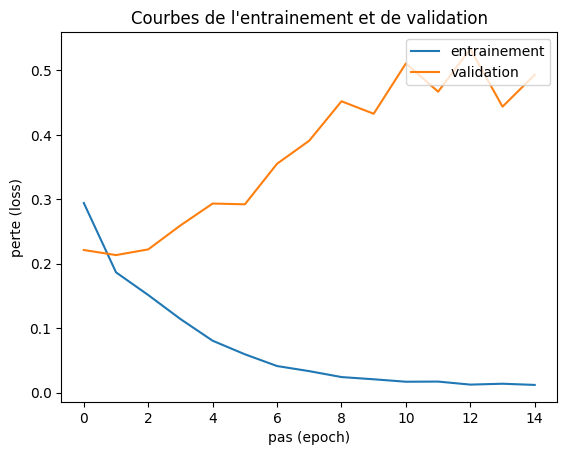

In [ ]:

import matplotlib.pyplot as plt
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Courbes de l\'entrainement et de validation') #('Training and validation loss curves (VGG19)')
plt.ylabel('perte (loss)')
plt.xlabel('pas (epoch)')
plt.legend(['entrainement', 'validation'], loc='upper right')
plt.show()

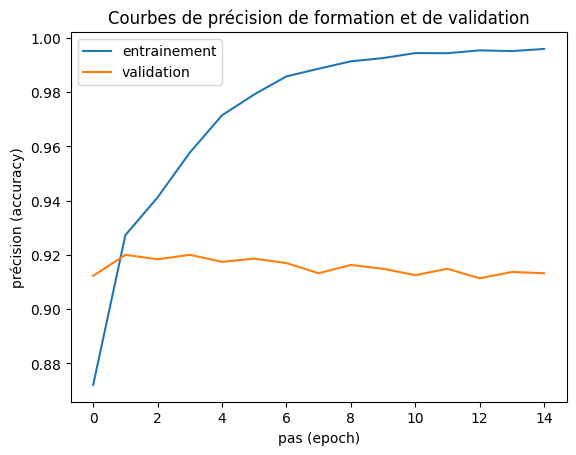

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Courbes de précision de formation et de validation') # ('Training and validation accuracy curves (VGG19)')
plt.ylabel('précision (accuracy)')
plt.xlabel('pas (epoch)')
plt.legend(['entrainement', 'validation'], loc='upper left')
plt.show()

In [ ]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=EPOCHS*2
)

Epoch 1/30
133/133 [==============================] - 27s 204ms/step - loss: 0.2484 - accuracy: 0.9133
Epoch 2/30
133/133 [==============================] - 27s 204ms/step - loss: 0.1350 - accuracy: 0.9486
Epoch 3/30
133/133 [==============================] - 27s 203ms/step - loss: 0.0811 - accuracy: 0.9739
Epoch 4/30
133/133 [==============================] - 27s 203ms/step - loss: 0.0405 - accuracy: 0.9882
Epoch 5/30
133/133 [==============================] - 27s 204ms/step - loss: 0.0272 - accuracy: 0.9910
Epoch 6/30
133/133 [==============================] - 27s 204ms/step - loss: 0.0223 - accuracy: 0.9932
Epoch 7/30
133/133 [==============================] - 27s 204ms/step - loss: 0.0173 - accuracy: 0.9936
Epoch 8/30
133/133 [==============================] - 27s 204ms/step - loss: 0.0083 - accuracy: 0.9981
Epoch 9/30
133/133 [==============================] - 27s 204ms/step - loss: 0.0032 - accuracy: 0.9998
Epoch 10/30
133/133 [==============================] - 27s 204ms/step - l

In [ ]:
_dir_path = '/content/gdrive/MyDrive/machine_learning/nlp_project/'

# Sauvegarder les poids du modèle...
model.save_weights(_dir_path+'outputs/xbert_model-4-val.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NotImplementedError: 
Layer ModuleWrapper was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

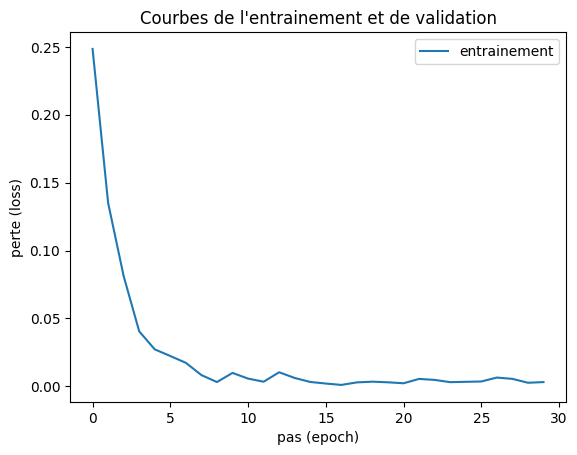

In [ ]:
history = train_history_2.history
import matplotlib.pyplot as plt
plt.plot(history['loss'])
#plt.plot(history['val_loss'])
plt.title('Courbes de l\'entrainement et de validation') #('Training and validation loss curves')
plt.ylabel('perte (loss)')
plt.xlabel('pas (epoch)')
plt.legend(['entrainement', 'validation'], loc='upper right')
plt.show()

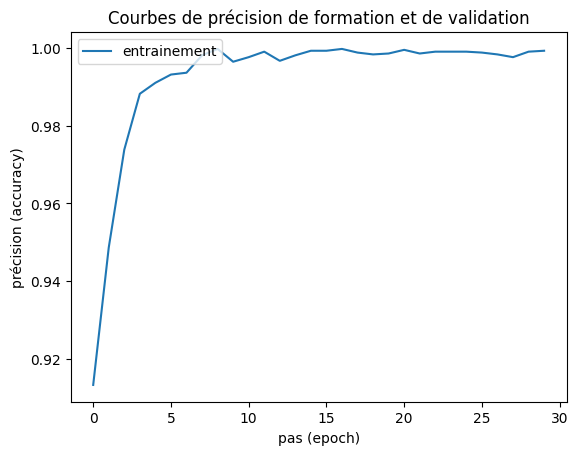

In [ ]:
plt.plot(history['accuracy'])
#plt.plot(history['val_accuracy'])
plt.title('Courbes de précision de formation et de validation') # ('Training and validation accuracy curves ')
plt.ylabel('précision (accuracy)')
plt.xlabel('pas (epoch)')
plt.legend(['entrainement', 'validation'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(valid_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

134/134 [==============================] - 10s 72ms/step - loss: 3.5245e-05 - accuracy: 1.0000
Loss: 3.524532439769246e-05
Accuracy: 1.0


In [ ]:
pred = model.predict(test_dataset, verbose=1)
#sub.to_csv('submission.csv', index=False)


268/268 [==============================] - 18s 68ms/step


In [ ]:
print("Auc: %.2f%%" % (roc_auc(pred,y_test)))

Auc: 0.97%


In [ ]:
examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...',
    'I love this movie',
    'I hate this movie',
    'I am bored',
    'I am tired',
    'I am happy',
    'I am sad',
    'I am angry',
    'I am scared',
]

## Tester le modèle entrainé

In [ ]:
from transformers import DistilBertTokenizer

# Charger le tokenizer
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')

# Phrase à tester
phrase = "You bastart"

# Prétraiter la phrase
inputs = tokenizer(phrase, return_tensors="tf", max_length=MAX_LEN, truncation=True, padding='max_length')

# Obtenir la prédiction
predictions = model.predict(inputs['input_ids'])

# Interpréter la prédiction
toxic_threshold = 0.5  # Définir un seuil
is_toxic = predictions[0, 0] > toxic_threshold

print(f"La phrase est {'toxique' if is_toxic else 'non-toxique'} avec une probabilité de {predictions[0, 0]:.2f}")

1/1 [==============================] - 0s 31ms/step
La phrase est toxique avec une probabilité de 1.00


## Tester le modèle enregistré

In [ ]:
_dir_path = '/content/gdrive/MyDrive/machine_learning/nlp_project/'

# Sauvegarder les poids du modèle
#model.save_weights(_dir_path+'outputs/bert_model-4.h5')

# Plus tard, pour charger les poids dans un nouveau modèle avec la même architecture
new_model = build_bert_model()  # Créez le modèle avec la même architecture
new_model.load_weights(_dir_path+'outputs/bert_model-3-val.h5')  # Chargez les poids sauvegardés

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
examples = [
    'Everythings goes bad today',
    'I am tired',
    'I am happy',
    'I am sad',
    'I am angry',
    'I am scared',
    'Je suis malade',
]

In [ ]:
examples = [
    'Je suis malade',
    'Je suis heureux',
    'Je t\'aime',
    'Je te haie',
    'Va chier',
    'Va dormir',
    'Te quiero',
    'Te quiero mucho',
    'Como estas',
    'Vete a la mierda',
    'culo',
]

In [ ]:
from transformers import DistilBertTokenizer
# Phrase à tester


def test_toxic(phrase):
  # Prétraiter la phrase
  inputs = tokenizer(phrase, return_tensors="tf", max_length=MAX_LEN, truncation=True, padding='max_length')

  # Obtenir la prédiction
  predictions = new_model.predict(inputs['input_ids'])

  # Interpréter la prédiction
  toxic_threshold = 0.5  # Définir un seuil
  is_toxic = predictions[0, 0] > toxic_threshold

  per = predictions[0, 0] * 100

  print(f"La **{phrase}** est {'toxique' if is_toxic else 'non-toxique'} avec une probabilité de {per:.2f}")

for phrase in examples:
  test_toxic(phrase)

1/1 [==============================] - 0s 28ms/step
La **Je suis malade** est toxique avec une probabilité de 96.90
1/1 [==============================] - 0s 28ms/step
La **Je suis heureux** est non-toxique avec une probabilité de 0.20
1/1 [==============================] - 0s 29ms/step
La **Je t'aime** est non-toxique avec une probabilité de 2.29
1/1 [==============================] - 0s 29ms/step
La **Je te haie** est toxique avec une probabilité de 98.71
1/1 [==============================] - 0s 29ms/step
La **Va chier** est toxique avec une probabilité de 99.21
1/1 [==============================] - 0s 29ms/step
La **Va dormir** est non-toxique avec une probabilité de 0.01
1/1 [==============================] - 0s 31ms/step
La **Te quiero** est non-toxique avec une probabilité de 0.11
1/1 [==============================] - 0s 30ms/step
La **Te quiero mucho** est non-toxique avec une probabilité de 0.01
1/1 [==============================] - 0s 29ms/step
La **Como estas** est non-to

# End Notes

This was my effort to share my learnings so that everyone can benifit from it.As this community has been very kind to me and helped me in learning all of this , I want to take this forward. I have shared all the resources I used to learn all the stuff .Join me and make these NLP competitions your first ,without being overwhelmed by the shear number of techniques used . It took me 10 days to learn all of this , you can learn it at your pace and dont give in , at the end of all this you will be a different person and it will all be worth it.


### I am attaching more resources if you want NLP end to end:

1) Books

* https://d2l.ai/
* Jason Brownlee's Books

2) Courses

* https://www.coursera.org/learn/nlp-sequence-models/home/welcome
* Fast.ai NLP Course

3) Blogs and websites

* Machine Learning Mastery
* https://distill.pub/
* http://jalammar.github.io/

**<span style="color:Red">This is subtle effort of contributing towards the community, if it helped you in any way please show a token of love by upvoting**